# 1. Modelo de detección de tumores cerebrales


## 1.1. Objetivo
El objetivo de este cuaderno será generar un modelo de inteligencia artificial capaz de distinguir, en base a una imagen tomada mediante resonancia magnética, si un paciente sufre o no de un tumor cerebral.

## 1.2 Código inicial
Una vez tengamos las librerias correctamente descargadas empezaremos importandolas al proyecto.

In [23]:
import os
import tensorflow as tf
import matplotlib as plt
from matplotlib import pyplot
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import tensorflow.keras as kr
import random
import ntpath

from dotenv import load_dotenv
from tensorflow.keras.utils import load_img, img_to_array
from numpy.core.defchararray import array
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model

In [44]:
load_dotenv()

True

## 1.5. Código común
Definiremos varias funciones que nos ayudarán a la hora de simplificar el código ya que, serán usadas, tanto a la hora de crear el modelo de detección como el modelo de clasificación.

### 1.3.1. Constantes
Definiremos una serie de constantes que nos servirán para poder parametrizar el modelo de una forma sencilla y rápida.

In [25]:
IMG_WIDTH = 150
IMG_HEIGHT = 150

#### 1.5.1.1. Constantes del modelo de detección
Definiremos una serie de constantes relacionadas con el modelo de detección de tumores tales como el nombre del modelo y el número de epochs.

In [26]:
MODEL_NAME = "detection_model.h5"
EPOCHS = 20 # @param {type:"number"}

### 1.5.2. Mostrar imágenes
Esta función nos permitirá visualizar de manera cómoda una batería de imágenes del dataset.

In [27]:
def show_images(path, rows, columns, title = ""):
  fig = plt.figure(figsize=(10, 10))

  for i in range(0, rows * columns):

    fig.add_subplot(rows, columns, i + 1)
    file_path = path + os.listdir(path)[i]

    img = mpimg.imread(file_path)
    plt.imshow(img)
    plt.title(title + str(i + 1))
    plt.axis('off')

  plt.show()

### 1.5.3. Mostrar imágen concreta
Esta función nos permitirá mostrar una imagen en concreto en base a una ruta indicada con un tamaño concreto.

In [28]:
def show_image(path, title = ""):
  healthy_brain_img = mpimg.imread(path)
  plt.imshow(healthy_brain_img)
  plt.title(title)
  plt.show()

### 1.5.4. Mostrar gráfica de acierto
Esta función servirá para mostrar un gráfico referente al acierto del modelo generado.

In [29]:
def show_accuracy(result):
  accuracy = result.history['accuracy']
  val_accuracy = result.history['val_accuracy']
  epochs = range(1, len(accuracy) + 1)
  plt.plot(epochs, accuracy, 'y', label='Training accuracy')
  plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

### 1.5.5. Mostrar gráfica de fallos
Esta función servirá para mostrar un gráfico referente a la pérdida del modelo generado.

In [30]:
def show_loss(result):
  loss = result.history['loss']
  val_loss = result.history['val_loss']
  epochs = range(1, len(loss) + 1)
  plt.plot(epochs, loss, 'y', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title('Training and validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

#2. Detección de tumores cerebrales
Vamos a empezar realizando el procesamiento de los datos y la creación del modelo de detección de tumores.

## 2.1. Colección de datos

### 2.1.1. ¿Que colección se va a utilizar?
La colección de datos, en este caso imágenes, que se va a utilizar a lo largo del proyecto es la siguiente: [Dataset tumores cerebrales](https://www.kaggle.com/code/ahmedhanymetawaa/brain-tumor-with-cnn-acc-99)

### 2.1.2. ¿Que contiene el dataset?
El dataset mencionado en el paso anterior contiene una gran cantidad de imágenes obtenidas mediante el escaneo del cortex cerebral de una persona. Dichas imagenes están clasificadas en dos grupos: aquellas en las cuales el paciente sufre un tumor cerebral y aquellas en las que se puede ver un cerebro sano y sin ningún tumor.

### 2.1.3 Código para la organización de los datos
A continuación desarrollaremos el código necesario para organizar los datos de la mejor manera posible, previamente hemos descargado las imágenes y las hemos depositado en el directorio *`.data/raw/ `*.

Definimos las rutas donde estarán almacenadas las imagenes que se usarán para el entrenamiento y la validación de las predicciones.



In [51]:
def format_path(path) -> str:
    return path.replace("/", os.sep).replace("\\", os.sep)

In [57]:
IN_PATH = "./data/"
IN_RAW_PATH = IN_PATH + "raw/"
TRAIN_IN_PATH = IN_PATH + "train/"
TEST_IN_PATH = IN_PATH + "test/"

BRAIN_TUMOR_PATH = format_path(os.path.join(os.getenv('PROJECT_PATH'), os.getenv("BRAIN_TUMOR_PATH"))) + os.sep
BRAIN_HEALTH_PATH = format_path(os.path.join(os.getenv('PROJECT_PATH'), os.getenv("BRAIN_HEALTH_PATH"))) + os.sep
print(BRAIN_TUMOR_PATH)

C:\Users\Javie\Documents\Proyectos\JSisquesDev\Cerebrum\datasets\detection\brain-tumor\


Visualizamos algunas de las imágenes de ejemplo para entender las difenrencias entre un cerebro sano y uno enfermo. Para ello crearemos una función que se encargará de mostrar n imagenes que le indiquemos en forma de celdas.

In [54]:
def showImages(path, rows, columns):

  fig = plt.figure(figsize=(10, 10))

  for i in range(0, rows * columns):

    fig.add_subplot(rows, columns, i + 1)
    file_path = path + os.listdir(path)[i]
  
    img = mpimg.imread(file_path)
    plt.imshow(img)
    plt.title("Cerebro " + str(i + 1))
    plt.axis('off')

  plt.show()

Mostramos unos cuantos cerebros sanos para entender cuando el órgano no contiene un tumor.

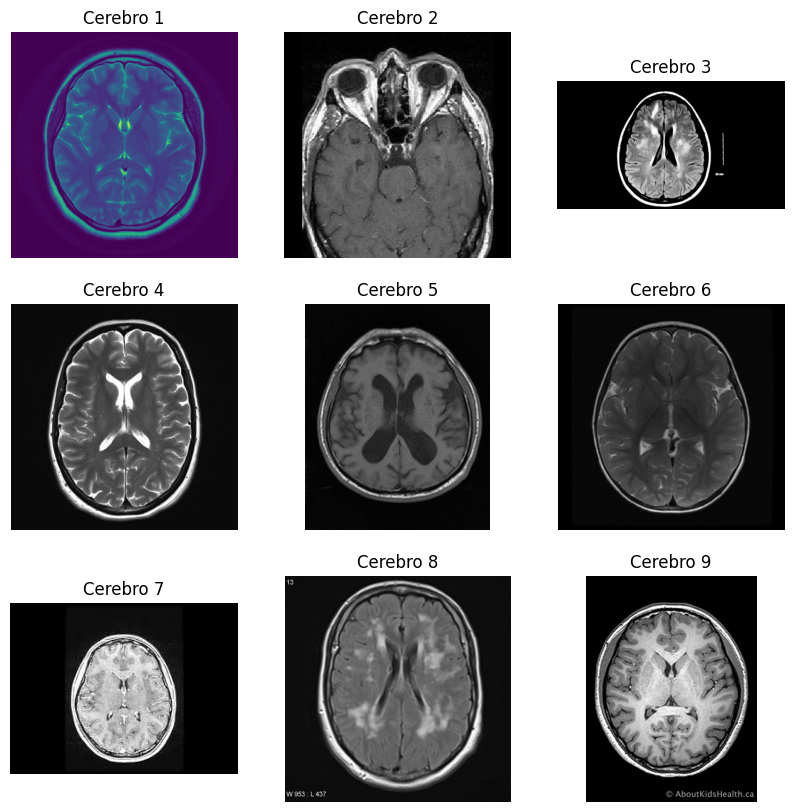

In [58]:
#IN_HEALTHY_PATH = IN_RAW_PATH + "healthy/"
showImages(BRAIN_HEALTH_PATH, 3, 3)

Mostramos unos cuantos cerebros sanos para entender cuando el organo contiene un tumor.

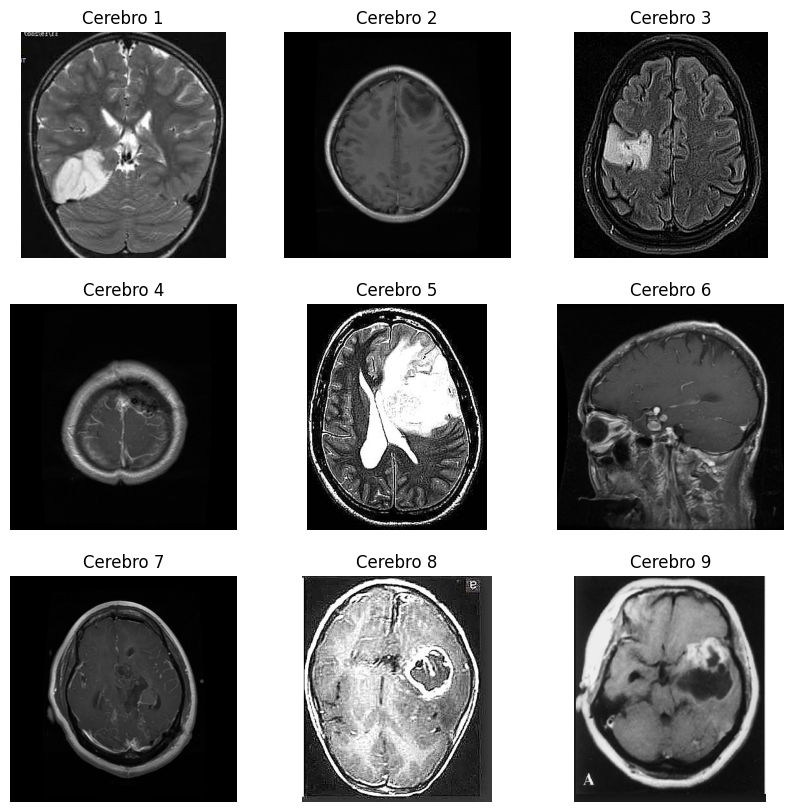

In [ ]:
IN_TUMOR_PATH = IN_RAW_PATH + "tumor/"
showImages(IN_TUMOR_PATH, 3, 3)

## 2.3. Exploración y limpieza de los datos

### 2.3.1 ¿Cuantas imágenes contiene nuestro dataset?
Sería recomendable averiguar cuantas imagenes contiene nuestro dataset, para ello, como hemos organizado previamente las imágenes en dos categorias, tumor y healthy, simpemente contaremos cuantos elementos hay en cada una de las carpetas.

In [ ]:
TOTAL_TUMOR_IMGS = os.listdir(IN_RAW_PATH + "tumor").__len__()
TOTAL_HEALTHY_IMGS = os.listdir(IN_RAW_PATH + "healthy").__len__()

print("Número de fotografías de cerebros con tumores: " + str(TOTAL_TUMOR_IMGS))
print("Número de fotografías de cerebros sanos: " + str(TOTAL_HEALTHY_IMGS))
print("Número total de fotografías: " + str(TOTAL_HEALTHY_IMGS + TOTAL_TUMOR_IMGS))

Número de fotografías de cerebros con tumores: 2513
Número de fotografías de cerebros sanos: 2087
Número total de fotografías: 4600


### 2.3.2. Tamaño de las imágenes
Como las imagenes del dataset pueden tener distinto tamaño será necesario establecer un tamaño normalizado para todas. En este caso optaremos por transformar las imagenes a una resolución de 150px de alto por 150px de ancho.

In [ ]:
PHOTO_HEIGHT = 150
PHOTO_WIDTH = 150

### 2.3.3. Prevención de sobreajuste
El siguiente paso será realizar una serie de transformaciones a los datos, a esta técnica se la conoce como ***data augmentation*** y consiste en aplicar una serie de modificaciones, en este caso sobre las imágenes, para obtener un conjunto de entrenamiento más amplio y variado.

Gracias a esto podemos prevenir el sobreajuste.

Para ello utilizaremos la función *`ImageDataGenerator()`*, y le aplicaremos los siguientes parámetros:

*   **Horizontal_flip**: Aplica un volteo sobre el eje horizontal de forma aleatoria.
*   **Vertical_flip**: Aplica un volteo sobre el eje vertical de forma aleatoria.
*   **Validation_split**: Reserva un porcentaje del dataset para utilizarlo como datos de validación.
*   **Rescale**: Normaliza los datos de la matriz para que esten comprendidos entre 0 y 1.
*   **Rotation_range**: Aplica una rotación aleatoria a las imágenes.




In [ ]:
data = ImageDataGenerator(
    rescale=1.0/255,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.2,
    rotation_range=20
)

### 2.3.4. Etiquetado y procesado de imágenes
El siguiente paso será etiquetar las imagenes del dataset, para ello utilizaremos la función *`flow_from_directory()`* la cual nos permitirá cargar, en función de una ruta establecida, las imágenes y aplicarles diferentes transformaciones para poder trabajar correctamente con ellas.

Podremos indicar el tamaño para cada imágen, el canal de colores (blanco y negro o RGB) y el conjunto de datos que se va a formar entre otras muchas cosas.

Dentro de esta función podemos usar varios parámetros:

*   **Target_size**: Aplica una reducción de tamaño a las fotografías según lo indicado.
*   **Batch_size**: Indica el número de ejemplos que se introducen en la red para que entrene de cada vez.
*   **Color_mode**: Establece los colores de las imagenes, en este caso será blanco y negro.
*   **Shuffle**: Mezcla todos los datos para hacerlos aleatorios.
*   **Class_mode**: Indicamos que se trata de una clasificación binaria, o existe el tumor en la imagen o no existe.
*   **Subset**: Indica el grupo de datos.

Deberemos de crear un conjunto de datos para el entrenamiento y otro para la validación.

In [ ]:
train_data = data.flow_from_directory(
    IN_RAW_PATH,
    target_size = (PHOTO_HEIGHT, PHOTO_WIDTH),
    batch_size = 64,
    color_mode = "grayscale",
    shuffle = True,
    class_mode = 'binary',
    subset = 'training'
)

Found 3681 images belonging to 2 classes.


In [ ]:
validation_data = data.flow_from_directory(
    IN_RAW_PATH,
    target_size = (PHOTO_HEIGHT, PHOTO_WIDTH),
    batch_size = 64,
    color_mode = "grayscale",
    shuffle = False,
    class_mode = 'binary',
    subset = 'validation'
)

Found 919 images belonging to 2 classes.


Podemos obtener las clases obtenidas de la siguiente manera.

In [ ]:
labels = train_data.class_indices
print(labels)

{'healthy': 0, 'tumor': 1}


## 2.4. Modelo



### 2.4.1. Cargamos el modelo si existe
Existe la posibilidad de que, previamente, se haya entrenado el modelo. En ese caso verificaremos si en la carpeta de modelos se encuentra el archivo con extensión .h5

Esto nos ayudará a ahorrar tiempo.

In [ ]:
path_model = './model/Model.h5'
if os.path.exists(path_model):
  model = load_model(path_model)
  print("Modelo previo cargado")
else:
  print("No se ha guardado ningún modelo previo")

No se ha guardado ningún modelo previo


### 2.4.2. Creación de la red neuronal convolucional
Para este proyecto lo más óptimo sería crear una red neuronal convolucional. Este tipo de red es ampliamente utilizada a la hora de analizar imágenes por lo que para nuestro caso servirá perfectamente.

Nuestra red va a contar con diferentes capas:

*   **Capa 1**: Será la capa de entra, aqui estableceremos el tamaño del input. Esta formada por una capa convolucional *`Conv2D()`* y una capa que nos permitirá ir reduciendo la dimensión de la fotografía mediante el método *`MaxPooling2D()`*. Devolverá un output de 32.
*   **Capa 2**: Igual que la anterior pero con un output de 64.
*   **Capa 3**: Igual que la anterior pero con un output de 128.
*   **Capa 4**: Será la encargada de transformar la matriz de píxeles en un array unidimensional. Aparte de eso se utilizará la función *`Dropout()`* para desconectar neuronas de forma aleatoria y conseguir mejores resultados.
*   **Capa 5**: Igual que la capa 2 pero con un output de 512.
*   **Capa 6**: Será la capa de salida, aquí se devolverá la predicción realizada, si devuelve un valor menor que 0.5 quiere decir que el cerebro se encuentra sano, en el caso de devolver un valor mayor o igual a 0.5 el cerebro estará enfermo.





In [ ]:
model  = kr.Sequential([
  # Capa 1 (Entrada)
  kr.layers.Conv2D(32, activation='relu', kernel_size=(3, 3), input_shape=(PHOTO_HEIGHT, PHOTO_WIDTH, 1)),
  kr.layers.MaxPooling2D(2,2),

  # Capa 2
  kr.layers.Conv2D(64, activation='relu', kernel_size=(3, 3)),
  kr.layers.MaxPooling2D(2,2),

  # Capa 3
  kr.layers.Conv2D(128, activation='relu', kernel_size=(3, 3)),
  kr.layers.MaxPooling2D(2,2),

  # Capa 4
  kr.layers.Flatten(),
  kr.layers.Dropout(0.5),

  # Capa 5
  kr.layers.Dense(512, activation='relu'),
  kr.layers.Dropout(0.2),

  # Capa 6 (salida)
  kr.layers.Dense(1, activation='sigmoid')
])

### 2.4.3. Compilamos el modelo
El siguiente paso será compilar el modelo que hemos creado anteriormente y mostrar un resumen del mismo.

In [ ]:
model.compile(
    optimizer = 'sgd',
    metrics = ['accuracy'],
    loss = 'binary_crossentropy'
)

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 128)       0

### 2.4.4. Estableciendo los checkpoints
Es necesario que, a medida que se va entrendando el modelo, vayamos guardando los avances en forma de "checkpoints". Para ello estableceremos una carpeta donde por cada epoch se ira guardando el progreso.

In [ ]:
! mkdir ./model

Configuramos los checkpoints

In [ ]:
path_model = './model/'

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint(path_model + "Model.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

### 2.4.5. Establecemos el número de epochs
Podemos definir un epoch como un ciclo o una iteración. En nuestro caso estableceremos este valor como 20.

In [ ]:
EPOCHS = 20

### 2.4.6. Entrenamiento
Una vez configurado todo lo anterior llega el momento de entrenar el modelo. Como hemos configurado los checkpoints por cada epoch se irá guardando un registro para no perder el avance.

In [ ]:
result = model.fit(train_data, epochs=EPOCHS, callbacks=[early_stopping, checkpoint], validation_data=validation_data)

Epoch 1/20
58/58 [==============================] - ETA: 0s - loss: 0.6875 - accuracy: 0.5569
Epoch 1: val_accuracy improved from -inf to 0.66921, saving model to ./model/Model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


58/58 [==============================] - 31s 310ms/step - loss: 0.6875 - accuracy: 0.5569 - val_loss: 0.6651 - val_accuracy: 0.6692
Epoch 2/20
58/58 [==============================] - ETA: 0s - loss: 0.6785 - accuracy: 0.6039
Epoch 2: val_accuracy improved from 0.66921 to 0.71273, saving model to ./model/Model.h5
58/58 [==============================] - 17s 293ms/step - loss: 0.6785 - accuracy: 0.6039 - val_loss: 0.6465 - val_accuracy: 0.7127
Epoch 3/20
58/58 [==============================] - ETA: 0s - loss: 0.6656 - accuracy: 0.6129
Epoch 3: val_accuracy improved from 0.71273 to 0.71708, saving model to ./model/Model.h5
58/58 [==============================] - 17s 286ms/step - loss: 0.6656 - accuracy: 0.6129 - val_loss: 0.6244 - val_accuracy: 0.7171
Epoch 4/20
58/58 [==============================] - ETA: 0s - loss: 0.6526 - accuracy: 0.6140
Epoch 4: val_accuracy did not improve from 0.71708
58/58 [==============================] - 16s 281ms/step - loss: 0.6526 - accuracy: 0.6140 - v

## 2.5. Pruebas y evaluación del modelo
Una vez entrenado el modelo podemos comprobar cual es el porcentaje de que, dada una imagen, acierte en la hipotesis de que contenga un tumor cerebral.

### 2.5.1. Porcentaje de exito y error
Podemos evaluar el porcentaje de éxito y error de nuestro modelo tanto con los datos de entrenamiento como con los de validación.

Como podemos ver, al ejecutar el código, obtenemos más de un 85% de acierto y un 20% de error sobre las imagenes utilizadas para el entreno y más de un 90% de acierto con un 20% de error en las imagenes utilizadas para la validación.

In [ ]:
train_loss, train_success = model.evaluate(train_data)
validation_loss, validation_success = model.evaluate(validation_data)

15/15 [==============================] - 3s 170ms/step - loss: 0.5218 - accuracy: 0.7443


### 2.5.2. Métricas
Según los datos obtenidos del modelo podemos representar el nivel de acierto y de fallo mediante gráficas.

#### 2.5.2.1. Porcentaje de acierto
Representamos el porcentaje de acierto tanto con los datos de entrenamiento como con los de validación.

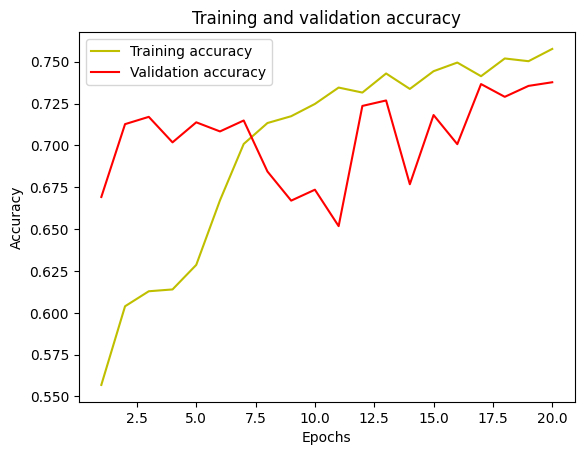

In [ ]:
show_accuracy(result)

#### 2.5.2.2. Porcentaje de error
Representamos el porcentaje de error tanto con los datos de entrenamiento como con los de validación.

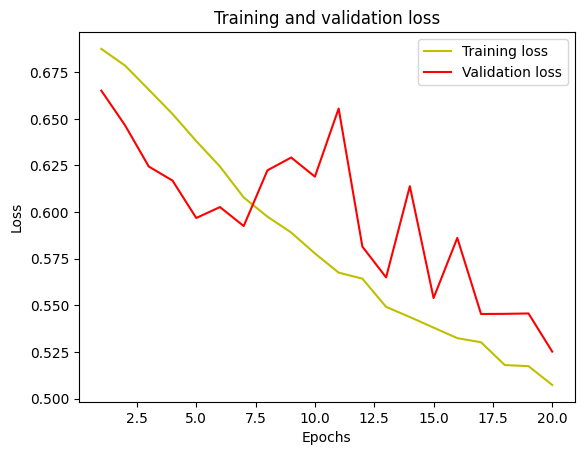

In [ ]:
show_loss(result)

## 2.6. Posible despliegue del modelo en ambientes de uso real

### 2.6.1. Casos de uso real

### 2.6.2. Ejemplo de uso real
En este apartado realizaremos un ejemplo de uso real del sistema creado. Para ello simplemente obtenendremos dos imágenes del dataset, una será de un cerebro sano y la otra de un cerebro enfermo.

#### 2.6.2.1. Obteniendo una imagen sana
Para obtener una imagen de un cerebro sano simplemente escogeremos al azar un archivo que esté dentro de la carpeta de imagenes clasificadas como sanas.

In [ ]:
def showImage(path, title = ""):
  healthy_brain_img = mpimg.imread(path)
  plt.imshow(healthy_brain_img)
  plt.title(title)
  plt.show()

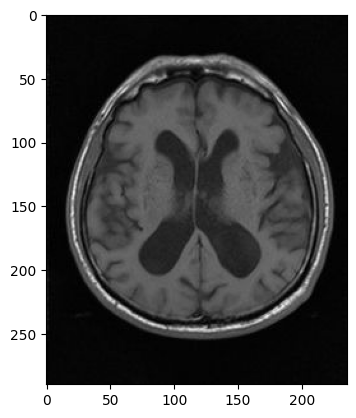

In [ ]:
healthy_brain_path = IN_HEALTHY_PATH + os.listdir(IN_HEALTHY_PATH)[random.randint(0, TOTAL_HEALTHY_IMGS)]
showImage(healthy_brain_path)

#### 2.6.2.2. Obteneindo una imagen enferma
Para obtener una imagen de un cerebro enfermo haremos lo mismo que en el paso anterior pero esta vez sobre la carpeta de imagenes de cerebros con tumores.

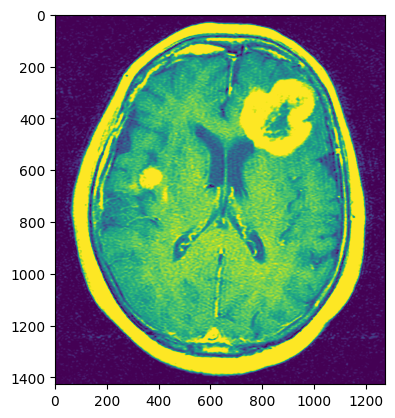

In [ ]:
tumor_brain_path = IN_TUMOR_PATH + os.listdir(IN_TUMOR_PATH)[random.randint(0, TOTAL_TUMOR_IMGS)]
showImage(tumor_brain_path)

#### 2.6.2.3. Clasificando las imágenes
Una vez obtenidas ambas imagenes unicamente tendremos que procesarlas para que sean aceptadas por la red neuronal. Para ello haremos lo mismo que hicimos a la hora de procesar y limpiar los datos.

1/1 [==============================] - 0s 191ms/step
[[0.]]
Cerebro sano


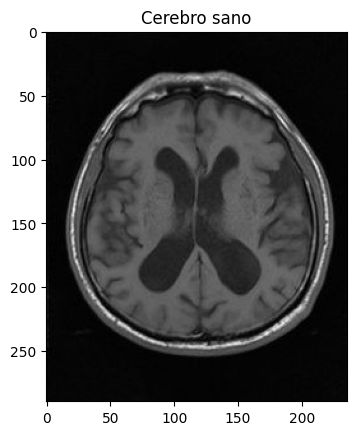

In [ ]:
img = load_img(healthy_brain_path, target_size=(150, 150), color_mode="grayscale")
prediction = model.predict(np.expand_dims(img, 0))
print(prediction)

prediction = "Cerebro sano" if prediction < 0.5 else "Cerebro con tumor"
print(prediction)

showImage(healthy_brain_path, title=prediction)

1/1 [==============================] - 0s 17ms/step
[[1.]]
Cerebro sano


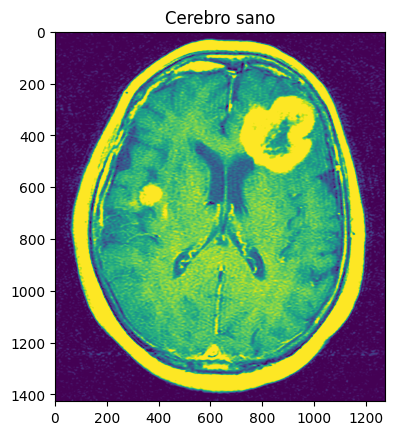

In [ ]:
img = load_img(tumor_brain_path, target_size=(150, 150), color_mode="grayscale")
prediction = model.predict(np.expand_dims(img, 0))
print(prediction)

prediction = "Cerebro sano" if prediction >= 0.5 else "Cerebro con tumor"
print(prediction)

showImage(tumor_brain_path, title=prediction)